# BIG DATA FINAL PROJECT: Pneumonia Identification from X-Ray Images
Álvaro Arrayás Ruiz and Jaime Castro Cernadas

## Environment Setup and Data Download



In [1]:
# Grant Colab access to Google Drive stored files like a local directory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import needed libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [3]:
# Set Kaggle API credentials directory
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

# Copy the Kaggle API key from Google Drive to Colab and set permissions
!cp "/content/drive/MyDrive/BigData_FinalProject/kaggle.json" "/content"
!chmod 600 /content/kaggle.json

In [4]:
# Download and extract the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d /content/dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/dataset/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## SparkSession Configuration

In [7]:
# Initialize Spark session for local execution
appname = "Chest X-Ray Analysis"
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()
spark

## Loading Train, Test, and Validation Data into PySpark DataFrames

In [8]:
# Define file paths for train data
train_normal_path = "/content/dataset/chest_xray/train/NORMAL"
train_pneumonia_path = "/content/dataset/chest_xray/train/PNEUMONIA"

# Create list of image file paths with labels (0 for Normal, 1 for Pneumonia)
train_normal_images = [(os.path.join(train_normal_path, f), 0) for f in os.listdir(train_normal_path) if f.endswith(".jpeg")]
train_pneumonia_images = [(os.path.join(train_pneumonia_path, f), 1) for f in os.listdir(train_pneumonia_path) if f.endswith(".jpeg")]

# Combine Normal and Pneumonia images into one list
train_data = train_normal_images + train_pneumonia_images

# Define schema for the DataFrame
schema = StructType([
    StructField("image_path", StringType(), True),
    StructField("label", IntegerType(), True)
])

# Create a PySpark DataFrame from the image paths and labels
train_sdf = spark.createDataFrame(train_data, schema=schema)

# Display the first 5 rows of the DataFrame
train_sdf.show(5, truncate=False)

+------------------------------------------------------------------+-----+
|image_path                                                        |label|
+------------------------------------------------------------------+-----+
|/content/dataset/chest_xray/train/NORMAL/IM-0341-0001.jpeg        |0    |
|/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-0465-0001.jpeg|0    |
|/content/dataset/chest_xray/train/NORMAL/IM-0483-0001.jpeg        |0    |
|/content/dataset/chest_xray/train/NORMAL/IM-0141-0001.jpeg        |0    |
|/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-0643-0001.jpeg|0    |
+------------------------------------------------------------------+-----+
only showing top 5 rows



In [9]:
# Count the number of images per label in the train dataset
train_sdf.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 3875|
|    0| 1341|
+-----+-----+



In [10]:
# Define file paths for test data
test_normal_path = "/content/dataset/chest_xray/test/NORMAL"
test_pneumonia_path = "/content/dataset/chest_xray/test/PNEUMONIA"

# Create list of image file paths with labels (0 for Normal, 1 for Pneumonia)
test_normal_images = [(os.path.join(test_normal_path, f), 0) for f in os.listdir(test_normal_path) if f.endswith(".jpeg")]
test_pneumonia_images = [(os.path.join(test_pneumonia_path, f), 1) for f in os.listdir(test_pneumonia_path) if f.endswith(".jpeg")]

# Combine Normal and Pneumonia images into one list
test_data = test_normal_images + test_pneumonia_images

# Define schema for the DataFrame
schema = StructType([
    StructField("image_path", StringType(), True),
    StructField("label", IntegerType(), True)
])

# Create a PySpark DataFrame from the image paths and labels
test_sdf = spark.createDataFrame(test_data, schema=schema)

# Display the first 5 rows of the DataFrame
test_sdf.show(5, truncate=False)

+-----------------------------------------------------------------+-----+
|image_path                                                       |label|
+-----------------------------------------------------------------+-----+
|/content/dataset/chest_xray/test/NORMAL/NORMAL2-IM-0073-0001.jpeg|0    |
|/content/dataset/chest_xray/test/NORMAL/NORMAL2-IM-0206-0001.jpeg|0    |
|/content/dataset/chest_xray/test/NORMAL/IM-0093-0001.jpeg        |0    |
|/content/dataset/chest_xray/test/NORMAL/NORMAL2-IM-0052-0001.jpeg|0    |
|/content/dataset/chest_xray/test/NORMAL/IM-0030-0001.jpeg        |0    |
+-----------------------------------------------------------------+-----+
only showing top 5 rows



In [11]:
# Count the number of images per label in the test dataset
test_sdf.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  390|
|    0|  234|
+-----+-----+



In [12]:
# Define file paths for validation data
val_normal_path = "/content/dataset/chest_xray/val/NORMAL"
val_pneumonia_path = "/content/dataset/chest_xray/val/PNEUMONIA"

# Create list of image file paths with labels (0 for Normal, 1 for Pneumonia)
val_normal_images = [(os.path.join(val_normal_path, f), 0) for f in os.listdir(val_normal_path) if f.endswith(".jpeg")]
val_pneumonia_images = [(os.path.join(val_pneumonia_path, f), 1) for f in os.listdir(val_pneumonia_path) if f.endswith(".jpeg")]

# Combine Normal and Pneumonia images into one list
val_data = val_normal_images + val_pneumonia_images

# Define schema for the DataFrame
schema = StructType([
    StructField("image_path", StringType(), True),
    StructField("label", IntegerType(), True)
])

# Create a PySpark DataFrame from the image paths and labels
val_sdf = spark.createDataFrame(val_data, schema=schema)

# Display the first 5 rows of the DataFrame
val_sdf.show(5, truncate=False)

+----------------------------------------------------------------+-----+
|image_path                                                      |label|
+----------------------------------------------------------------+-----+
|/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg|0    |
|/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg|0    |
|/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg|0    |
|/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg|0    |
|/content/dataset/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg|0    |
+----------------------------------------------------------------+-----+
only showing top 5 rows



In [13]:
# Count the number of images per label in the validation dataset
val_sdf.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|    8|
|    1|    8|
+-----+-----+



## Exploratory Data Analysis

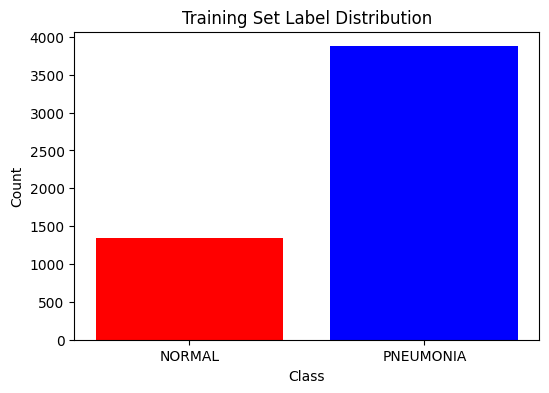

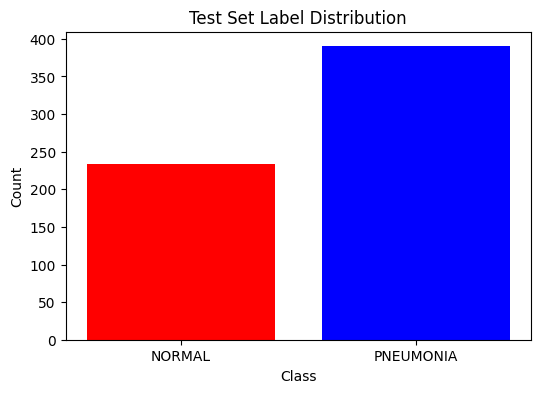

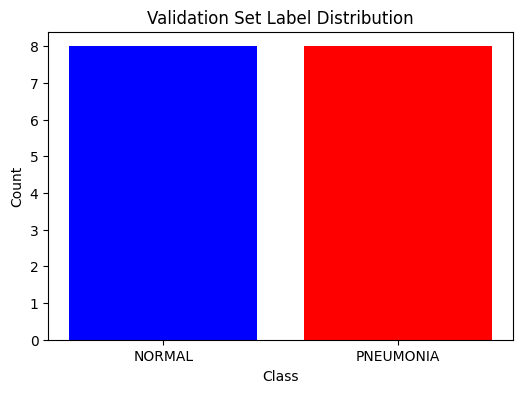

In [14]:
import matplotlib.pyplot as plt

# Function to visualize the distribution of labels in each dataset
def plot_label_distribution(data, title):
    label_counts = data.groupBy("label").count().toPandas()
    plt.figure(figsize=(6, 4))
    plt.bar(label_counts["label"], label_counts["count"], color=["blue", "red"])
    plt.xticks([0, 1], ["NORMAL", "PNEUMONIA"])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

# Perform EDA by visualizing label distribution in train, test, and validation sets
plot_label_distribution(train_sdf, "Training Set Label Distribution")
print("")
plot_label_distribution(test_sdf, "Test Set Label Distribution")
print("")
plot_label_distribution(val_sdf, "Validation Set Label Distribution")

After visualizing the label distribution, a few sample X-ray images are displayed along with their corresponding labels.

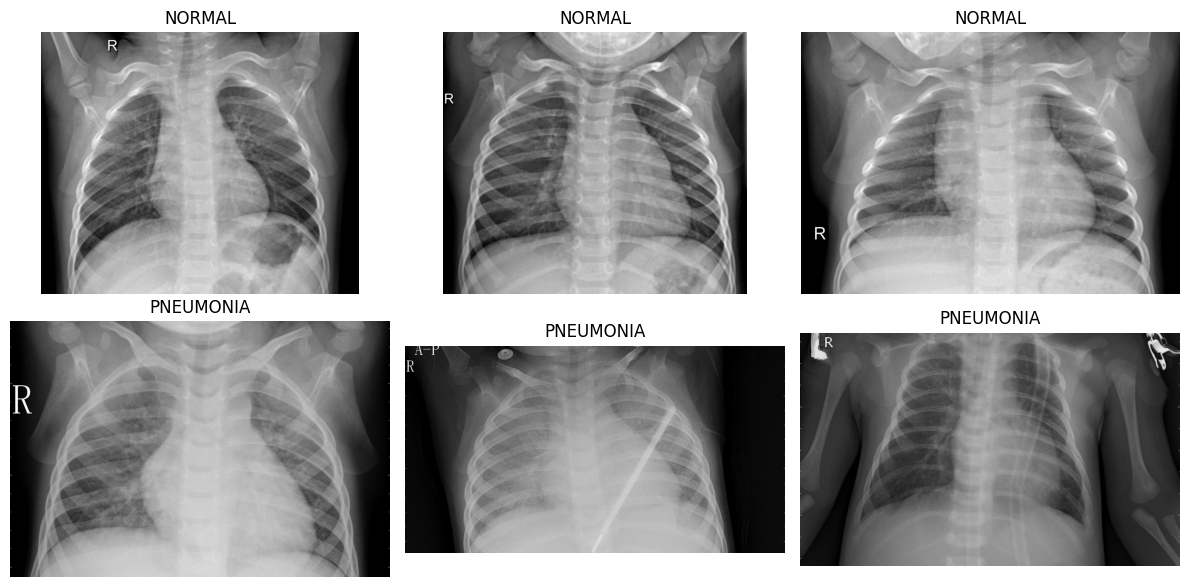

In [16]:
# Function to display sample images with corresponding labels
def show_sample_images(data, samples = 3):
    fig, axes = plt.subplots(2, samples, figsize = (12, 6))
    labels = {0: "NORMAL", 1: "PNEUMONIA"}

    for label in [0, 1]:
        images = data.filter(col("label") == label).select("image_path").limit(samples).toPandas()["image_path"].tolist()
        for i, img_path in enumerate(images):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            axes[label, i].imshow(img, cmap="gray")
            axes[label, i].axis("off")
            axes[label, i].set_title(labels[label])

    plt.tight_layout()
    plt.show()

# Display sample images from the training dataset
show_sample_images(train_sdf)

## Feature Extraction from Images Using ResNet50 Model


In [17]:
# Since PySpark does not work with raw images and does not support CNNs we use TensorFlow to convert images into deep-learning feature vectors
import tensorflow as tf
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
import cv2

# Load Pretrained ResNet50 Model
model = tf.keras.applications.ResNet50(weights = "imagenet", include_top = False, pooling = "avg")

# Define a function to load and process images
def extract_features(image_path):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size = (224, 224)) # We have to reduce the image size to 224x224
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis = 0)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        features = model.predict(img_array)
        return features.flatten().tolist()
    except:
        return None  # Handle errors in case a file is missing

# Convert function to PySpark UDF
extract_features_udf = udf(extract_features, ArrayType(FloatType()))

# Apply to DataFrames
train_sdf = train_sdf.withColumn("features", extract_features_udf(train_sdf["image_path"]))
test_sdf = test_sdf.withColumn("features", extract_features_udf(test_sdf["image_path"]))
val_sdf = val_sdf.withColumn("features", extract_features_udf(val_sdf["image_path"]))

# Drop unnecessary column (image_paths)
train_sdf = train_sdf.select("features", "label")
test_sdf = test_sdf.select("features", "label")
val_sdf = val_sdf.select("features", "label")

# Display the resulting vectors for each dataset
train_sdf.show(5)
test_sdf.show(5)
val_sdf.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[4.1976147, 0.788...|    0|
|[1.2548782, 1.050...|    0|
|[2.1122215, 1.586...|    0|
|[4.1491737, 1.135...|    0|
|[2.6271424, 1.916...|    0|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.2530066, 0.164...|    0|
|[1.5515311, 1.202...|    0|
|[3.3233244, 0.772...|    0|
|[2.143196, 0.5028...|    0|
|[3.239576, 1.9028...|    0|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.0000358, 0.812...|    0|
|[2.2890108, 0.901...|    0|
|[2.24038, 1.06725...|    0|
|[1.9594879, 1.655...|    0|
|[2.5940855, 0.950...|    0|
+--------------------+-----+
only showing top 5 rows



## Conversion of Feature Arrays to Vector for PySpark Compatibility

In [18]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# Define a UDF to convert arrays into Spark ML Vectors
array_to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())

# Convert the extracted features into Vector format
train_sdf = train_sdf.withColumn("features", array_to_vector_udf("features"))
test_sdf = test_sdf.withColumn("features", array_to_vector_udf("features"))
val_sdf = val_sdf.withColumn("features", array_to_vector_udf("features"))

# Use VectorAssembler to ensure compatibility with Spark ML models
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(inputCols=["features"], outputCol="features_vector")
train_sdf = vector_assembler.transform(train_sdf).select("features_vector", "label")
test_sdf = vector_assembler.transform(test_sdf).select("features_vector", "label")
val_sdf = vector_assembler.transform(val_sdf).select("features_vector", "label")

# Display the transformed vectors
train_sdf.show(5)
test_sdf.show(5)
val_sdf.show(5)

+--------------------+-----+
|     features_vector|label|
+--------------------+-----+
|[4.19761466979980...|    0|
|[1.25487816333770...|    0|
|[2.11222147941589...|    0|
|[4.14917373657226...|    0|
|[2.62714242935180...|    0|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|     features_vector|label|
+--------------------+-----+
|[1.25300657749176...|    0|
|[1.55153107643127...|    0|
|[3.32332444190979...|    0|
|[2.14319610595703...|    0|
|[3.23957610130310...|    0|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|     features_vector|label|
+--------------------+-----+
|[2.00003576278686...|    0|
|[2.28901076316833...|    0|
|[2.24038004875183...|    0|
|[1.95948791503906...|    0|
|[2.59408545494079...|    0|
+--------------------+-----+
only showing top 5 rows



## Model Evaluation and Testing

In [20]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Logistic Regression Model
lr = LogisticRegression(featuresCol = "features_vector", labelCol = "label")

# Random Forest Model
rf = RandomForestClassifier(featuresCol = "features_vector", labelCol = "label", numTrees = 100)

# MLP Model (Multi-Layer Perceptron)
input_dim = train_sdf.select("features_vector").first()[0].size  # Get input size dynamically
mlp = MultilayerPerceptronClassifier(featuresCol = "features_vector", labelCol = "label",
                                     layers = [input_dim, 64, 32, 10], maxIter = 100)

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "accuracy")

### Logistic Regression

In [22]:
# Train each model
lr_model = lr.fit(train_sdf)

# Predict on validation data
lr_predictions = lr_model.transform(val_sdf)

# Get accuracy scores
lr_acc = evaluator.evaluate(lr_predictions)

print(f"Validation Accuracy - Logistic Regression: {lr_acc * 100:.2f}%")

Validation Accuracy - Logistic Regression: 93.75%


#### Cross-validation

In [24]:
# Hyperparameter Grid for Logistic Regression
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross-Validation setup
crossval_lr = CrossValidator(estimator = lr, estimatorParamMaps = lr_param_grid, evaluator = evaluator,
                             numFolds = 5)  # 5-fold cross-validation

# Fit Cross-Validator to find the best model
cv_lr_model = crossval_lr.fit(train_sdf)

# Get the best model from Cross-Validation
cv_best_lr_model = cv_lr_model.bestModel

# Predict on Validation Data
cv_lr_predictions = cv_best_lr_model.transform(val_sdf)

# Compute accuracy
cv_lr_acc = evaluator.evaluate(cv_lr_predictions)

# Print best model accuracy
print(f" Best Logistic Regression Model Validation Accuracy: {cv_lr_acc * 100:.2f}%")

KeyboardInterrupt: 

### Test Best Logistic Regression Model

In [ ]:
# Predict on test data using the best model from cross-validation
cv_lr_test_predictions = cv_best_lr_model.transform(test_sdf)

# Evaluate test accuracy
cv_lr_test_acc = evaluator.evaluate(cv_lr_test_predictions)

# Print final test accuracy
print(f"Final Test Accuracy - Logistic Regression: {cv_lr_test_acc * 100:.2f}%")

### Random Forest

In [ ]:
# Hyperparameter Grid for Random Forest
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Cross-Validation setup
crossval_rf = CrossValidator(estimator = rf, estimatorParamMaps = rf_param_grid, evaluator = evaluator,
                             numFolds = 5)  # 5-fold cross-validation

# Fit CrossValidator to find the best model
cv_rf_model = crossval_rf.fit(train_sdf)

# Get the best model from Cross-Validation
cv_best_rf_model = cv_rf_model.bestModel

# Predict on Validation Data
cv_rf_predictions = cv_best_rf_model.transform(val_sdf)

# Compute accuracy
cv_rf_acc = evaluator.evaluate(cv_rf_predictions)

# Print best model accuracy
print(f" Best Random Forest Model Validation Accuracy: {cv_rf_acc * 100:.2f}%")

### Test Best Random Forest Model

In [ ]:
# Predict on test data using the best model from cross-validation
cv_rf_test_predictions = cv_best_rf_model.transform(test_sdf)

# Evaluate test accuracy
cv_rf_test_acc = evaluator.evaluate(cv_rf_test_predictions)

# Print final test accuracy
print(f"Final Test Accuracy - Random Forest: {cv_rf_test_acc * 100:.2f}%")

### Multilayer Perceptron

In [ ]:
# Hyperparameter Grid for MLP
mlp_param_grid = ParamGridBuilder() \
    .addGrid(mlp.layers, [[input_dim, 128, 64, 10], [input_dim, 64, 32, 10]]) \
    .addGrid(mlp.maxIter, [50, 100, 200]) \
    .build()

# Cross-Validation setup
crossval_mlp = CrossValidator(estimator = mlp, estimatorParamMaps = mlp_param_grid, evaluator = evaluator,
                              numFolds = 5)  # 5-fold cross-validation

# Fit CrossValidator to find the best model
cv_mlp_model = crossval_mlp.fit(train_sdf)

# Get the best model from Cross-Validation
cv_best_mlp_model = cv_mlp_model.bestModel

# Predict on Validation Data
cv_mlp_predictions = cv_best_mlp_model.transform(val_sdf)

# Compute accuracy
cv_mlp_acc = evaluator.evaluate(cv_mlp_predictions)

# Print best model accuracy
print(f" Best MLP Model Validation Accuracy: {cv_mlp_acc * 100:.2f}%")

### Test Best Multilayer Perceptron Model

In [ ]:
# Predict on test data using the best model from cross-validation
cv_mlp_test_predictions = cv_best_mlp_model.transform(test_sdf)

# Evaluate test accuracy
cv_mlp_test_acc = evaluator.evaluate(cv_mlp_test_predictions)

# Print final test accuracy
print(f"Final Test Accuracy - MLP: {cv_mlp_test_acc * 100:.2f}%")